\left{
    \begin{array}{r c l}
        \frac{dI}{d t}   & = &  \beta(\gamma)(N - I)I (\alpha + \mu) I \\
        \frac{d \alpha}{d t}   & = & a  \alpha [b^{'}(\alpha)  (N - I + \sigma I) - 1 ] \\
        \frac{d x}{d t}   & = & \sigma x (1 -x) (\alpha I - \kappa)
\end{array}
\right.

# Library

In [1]:

import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

## Choix de l'équation sur virulence prevalence

In [2]:
def risk1(alpha, i ):
        return(alpha) 

def risk2(alpha, i ,N):
        return(i/N) 

def vrisk3(alpha, i ,N):
        return(alpha*(i/N))


# Choix du trade offs

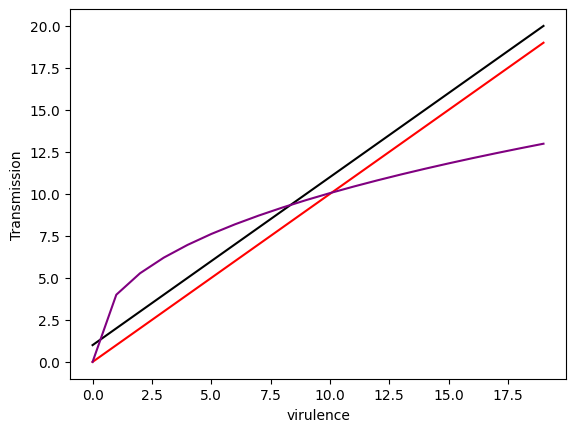

In [22]:
c = 4
k=0.4

def beta(x,c, k ):
    return(c*x**k)
def beta2(x,c, k ):
    return(c*k*x**(k-1))

droite1 = np.zeros(20)
droite2 = np.zeros(20)
droite3 = np.zeros(20)
for y in range(20):
    droite1[y] = y
    droite2[y] = y+1
    droite3[y]=beta(y,c,k)
figtrade, ax1 = plt.subplots()
ax1.plot(range(20),droite1,"red")
ax1.plot(range(20),droite2,"black")
ax1.plot(range(20),droite3,"purple")
ax1.set_xlabel('virulence')
ax1.set_ylabel('Transmission')
plt.show(figtrade)
        
        


In [53]:
################################################# Coeur du modèle

# Ancienne version non fonctionelle
def model(Y0, t ,B, c, k, mu, A, supinfec,sig,pay,func) :
    S, I , alpha, x = Y0
    S =Y0[0]
    I =Y0[1]
    alpha =Y0[2]
    x =Y0[3]
    N = S + I

    dS = B - (1 - x) * beta(alpha ,c , k) * I * S - mu * S
    dI = (1 - x) * beta(alpha ,c , k) * I * S - alpha * I - I *mu
    dalpha = A  *((1-x)*beta2(alpha,c, k) * (S + I* supinfec) - 1 )  
    dx =  sig*x * (1-x)*(func(alpha,I,N) - pay)
    return(dS,dI,dalpha,dx)


def cooperators(s,i , alpha,x ,parms = [B, c, k, mu, A, supinfec,sig,pay] ):
    B, c, k, mu, A, supinfec,sig,pay = parms
    dx =  sig*x * (1-x)*(i/(s + i) - pay)
    return(dx) 

def virulence(s,i , alpha,x, parms = [B, c, k, mu, A, supinfec,sig,pay]):
    B, c, k, mu, A, supinfec,sig,pay= parms
    
    dalpha = A  *alpha* ((1-x)*beta2(alpha,c, k) * (S + I* supinfec) - 1 )    
    return(dalpha)

def sains(s,i , alpha,x, parms = [B, c, k, mu, A, supinfec,sig,pay]):
    B, c, k, mu, A, supinfec,sig,pay= parms
    
    ds = B - (1 -x) * beta(alpha, c ,k) * S* I - mu*S
    return(ds)


#######Runge kunta d'ordre 4
def runge_kunta_4(pas,S, I , alpha,x,parms = [B, c, k, mu, A, supinfec,sig,pay],name = None):
    B, c, k, mu, A, supinfec,sig,pay= parms

    if name == "sain":
        k1 = sains(S,I , alpha,x,parms = [B, c, k, mu, A, supinfec,sig,pay])
        k2 = sains(S +k1*pas/2,I ,alpha,x, parms = [B, c, k, mu, A, supinfec,sig,pay])
        k3 = sains(S+ k2*pas/2 ,I ,alpha ,x  ,parms = [B, c, k, mu, A, supinfec,sig,pay])
        k4 = sains(S+ k3*pas ,I ,alpha ,x  ,parms = [B, c, k, mu, A, supinfec,sig,pay])
        return(S + pas*(k1 + 2*k2 + 2*k3 +k4)/6) 
    
    if name == "alpha":
        k1 = virulence(S,I , alpha,x,parms = [B, c, k, mu, A, supinfec,sig,pay])
        k2 = virulence(S,I ,alpha + k1*pas/2 ,x, parms = [B, c, k, mu, A, supinfec,sig,pay])
        k3 = virulence(S,I ,alpha + k2*pas/2 ,x  ,parms = [B, c, k, mu, A, supinfec,sig,pay])
        k4 = virulence(S,I ,alpha + k3*pas ,x  ,parms = [B, c, k, mu, A, supinfec,sig,pay] )
        return(alpha + pas*(k1 + 2*k2 + 2*k3 +k4)/6) 
        
    if name == "coop":
        k1 = cooperators(S,I , alpha,x,parms = [B, c, k, mu, A, supinfec,sig,pay])
        k2 = cooperators(S,I ,alpha,x + k1*pas/2 , parms = [B, c, k, mu, A, supinfec,sig,pay] )
        k3 = cooperators(S,I ,alpha,x + k2*pas/2  ,parms = [B, c, k, mu, A, supinfec,sig,pay])
        k4 = cooperators(S,I ,alpha,x + k3*pas   ,parms = [B, c, k, mu, A, supinfec,sig,pay] )
        return(x + pas*(k1 + 2*k2 + 2*k3 +k4)/6) 




def better_ode( tmax, pas ,Y0,parms):
    ds,di ,dalpha ,dx =Y0
    B, c, k, mu, A, supinfec,sig,pay = parms

    tab= np.zeros((nbr_pas,3))
    
    t = np.linspace(0,tmax,nbr_pas)
    
    for y in range(len(t)):
        s = ds
        i = di
        alpha = dalpha
        x = dx
        tab[y,0] = s
        tab[y,1] = i
        tab[y,2] = alpha
        tab[y,3] = x
        #Evolution des compartiments
        
        ds = runge_kunta_4(pas, i , alpha,x,parms = [B, c, k, mu, A, supinfec,sig,pay], name = "sain" )
        dalpha = runge_kunta_4(pas, i , alpha,x,parms = [B, c, k, mu, A, supinfec,sig,pay], name = "alpha" )
        dx = runge_kunta_4(pas, i , alpha,x,parms = [B, c, k, mu, A, supinfec,sig,pay], name = "coop" )
        di = (i + pas * beta(alpha ,c , k)* (1 - x) * i*s)/(1 + pas*(alpha+mu) )
    
    return(tab)

## Choix des variables

## Simualtion simple

In [54]:
# sol = solve_ivp(model, y0 = [i0 , c0,x0], t_span = (0,tmax),args = (sig,supinfec,pay,c,k,A,p,q,N),method="RK45",dense_output=True)
# sol = sol.y
tmax = 100.0
pas = 0.1
nbr_pas = int(tmax/pas)
temps = np.linspace(0,tmax,nbr_pas)

B, c, k, mu, A, supinfec,sig,pay = 150,5,0.6,1,8.4,0.1,8,0.6


# sol = odeint(model, y0 = [S0,I0,x0,V0], t=temps,args = (B, c, k, mu, A, supinfec,sig,pay,risk2))
#model(Y0, t ,B, c, k, mu, A, supinfec,sig,pay,func)

s0,i0 , v0,x0 =1000,1,1,10
sol = better_ode( tmax , pas ,Y0 = [s0,i0 , v0,x0],parms =[B, c, k, mu, A, supinfec,sig,pay])
# (Y0, tmax, pas ,parms)



fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(temps,sol[:,0],"green")
ax1.plot(temps,sol[:,1],"red")
ax1.plot(temps,sol[:,2],"black")
ax2.plot(temps,sol[:,1],"purple")
ax2.set_ylim(-0.5,10)

ax1.set_xlabel('Temps')
ax1.set_ylabel('Prévalence', color='red')
ax2.set_ylabel('virulence', color='purple')

plt.show(fig1)

IndexError: index 3 is out of bounds for axis 1 with size 3

## Comportement du modèle en 3d

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


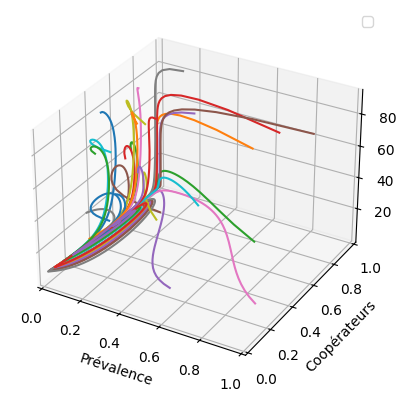

In [12]:
repet = 25

fig2 = plt.figure()
#ax = fig2.gca(projection='3d')
ax = plt.axes(projection='3d')
for i in range(repet):
    
    i0 = float(np.random.uniform(0.0001,0.99,1) )
    c0= float(np.random.uniform(0.01,100,1))
    x0 = float(np.random.uniform(0.001,0.9999,1))

    # sol = solve_ivp(model, y0 = [i0 , c0,x0], t_span = (0,tmax),args = (sig,supinfec,pay,c,k,A,p,q,N),method="RK45",dense_output=True)
    # sol = sol.y
    #sol = odeint(model, y0 = [i0 , c0,x0], t=temps,args = (sig,supinfec,pay,c,k,A,p,q,N))
    #sol = solve_ivp(model,[0,tmax], y0 = [i0 , c0,x0], t=temps,args = (sig,supinfec,pay,c,k,A,p,q,N),method="RK23")
    sol = better_ode( tmax , pas ,Y0 = [i0 , c0,x0],parms =[sig,supinfec,pay,c,k,A,p,q,N])
    
    x = sol[:,0]
    z = sol[:,1]
    y = sol[:,2]
    
    ax.plot(x, y, z)

ax.legend()
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xlabel('Prévalence')
ax.set_ylabel('Coopérateurs')
ax.set_zlabel('virulence')
plt.show(fig2)


# Multiple plot

In [ ]:
sig,supinfec,pay,c,k,A,p,q,N =

p=0.1
q=0.1
sol1 = better_ode( tmax , pas ,Y0 = [i0 , c0,x0],parms =[sig,supinfec,pay,c,k,A,p,q,N])

p=0.1
q=0.5
sol2 = better_ode( tmax , pas ,Y0 = [i0 , c0,x0],parms =[sig,supinfec,pay,c,k,A,p,q,N])

p=0.1
q=0.9
sol3 = better_ode( tmax , pas ,Y0 = [i0 , c0,x0],parms =[sig,supinfec,pay,c,k,A,p,q,N])

p=0.5
q=0.1
sol4 = better_ode( tmax , pas ,Y0 = [i0 , c0,x0],parms =[sig,supinfec,pay,c,k,A,p,q,N])

p=0.5
q=0.5
sol5 = better_ode( tmax , pas ,Y0 = [i0 , c0,x0],parms =[sig,supinfec,pay,c,k,A,p,q,N])

p=0.5
q=0.9
sol6 = better_ode( tmax , pas ,Y0 = [i0 , c0,x0],parms =[sig,supinfec,pay,c,k,A,p,q,N])


p=0.9
q=0.5
sol7 = better_ode( tmax , pas ,Y0 = [i0 , c0,x0],parms =[sig,supinfec,pay,c,k,A,p,q,N])

p=0.9
q=0.5
sol8 = better_ode( tmax , pas ,Y0 = [i0 , c0,x0],parms =[sig,supinfec,pay,c,k,A,p,q,N])

p=0.9
q=0.9
sol9 = better_ode( tmax , pas ,Y0 = [i0 , c0,x0],parms =[sig,supinfec,pay,c,k,A,p,q,N])




# (Y0, tmax, pas ,parms)

temps = np.linspace(0,tmax,nbr_pas)

fig1, axs = plt.subplots(3,3)
ax2 = ax1.twinx()
ax1.plot(temps,sol[:,0],"red")
ax1.plot(temps,sol[:,2],"black")
ax2.plot(temps,sol[:,1],"purple")
ax2.set_ylim(-0.5,10)

ax1.set_xlabel('Temps')
ax1.set_ylabel('Prévalence', color='red')
ax2.set_ylabel('virulence', color='purple')

plt.show(fig1)
